# CUDA - 實戰挑戰 4：圖像灰階轉換

### 💡我們總共會有三個執行的檔案
- <span style="color:royalblue"><b>input.py</b></span>：讀取圖片，生成可以給 grayscale.cu 的圖片
- <span style="color:royalblue"><b>gray_scale.cu</b></span>：進行灰階轉換（CPU + GPU）
- <span style="color:royalblue"><b>output.py</b></span>：顯示結果圖片

### 💡我們共有兩種圖片形式
- **.png/.jpg**：一般圖片檔
- **.bin**：處理用二進位檔

---

# <補充> .bin 檔


.bin 是一種原始二進位資料的檔案格式，  
非常輕巧、沒有壓縮，因此**非常適合 GPU 實驗中用來儲存圖片資料**！

ex: 十進制 220 → 二進制 11011100 （電腦實際儲存的）→ 十六進制 DC（工程師看的）

---

### 【一張 RBG 的彩色圖片】 color.png


這是 **RGB 三通道** 圖片，每個 pixel 會佔用 **3 個 byte（R, G, B）**  
→ 儲存為 .bin 時就是把所有像素的 RGB 值一個個寫入

**對 pixel 1 而言：**

若在 color.png 中為 R= 10, G= 20, B= 30

則在 color.bin 中為 0A 14 1E

**對 pixel 2 而言：**

若在 color.png 中為 R= 50, G= 60, B= 70

則在 color.bin 中為 32 3C 46

...（依此類推）

---

### 【一張灰階圖片】 gray.png

這是 **灰階單通道** 圖片，每個 pixel 只用 **1 個 byte** 表示亮度（0~255）

→ 儲存為 .bin 時，每個 pixel 只會寫入 1 個值

**對 pixel 1 而言：**

若在 gray.png 中為 220

則在 gray.bin 中為 DC

**對 pixel 2 而言：**

若在 gray.png 中為 30

則在 gray.bin 中為 1e

...（依此類推）

---


# 💡 執行順序：

1. **準備一張任意圖片檔**

  上傳任意一張想轉換的圖片，檔名隨意，大小隨意

  （因colab需取用圖片）

2. **執行 input.py**

  自動將圖片轉為 CUDA 可處理的格式：

  → 產生 `input.bin` 和 `meta.txt`

3. **執行 gray_scale.cu**
  
  將 input.bin 轉為灰階 output.bin
  
  → 產生：
    - `output_cpu.bin`：CPU 灰階結果  
    - `output_gpu1.bin`：GPU ver1 灰階結果  
    - `output_gpu2.bin`：GPU ver2 灰階結果  

4. **執行 output.py**

   讀取 `.bin` 檔案並將灰階結果顯示成圖片

  → 產生：
    - `output_cpu.png`：CPU 最終灰階圖片  
    - `output_gpu1.png`：GPU ver1 最終灰階圖片   
    - `output_gpu2.png`：GPU ver2 最終灰階圖片

     

###   【流程圖示例】  
<div style="text-align: center;">
  <img src="https://hackmd.io/_uploads/rJhkeYvtgl.png" width="900">
</div>

---


# 1. input.py

Saving 9147de1e-1df7-4365-8d97-3f6a0b0fd1af.png to 9147de1e-1df7-4365-8d97-3f6a0b0fd1af.png
| file_name:  9147de1e-1df7-4365-8d97-3f6a0b0fd1af.png
| width X height: 1024 x 1024


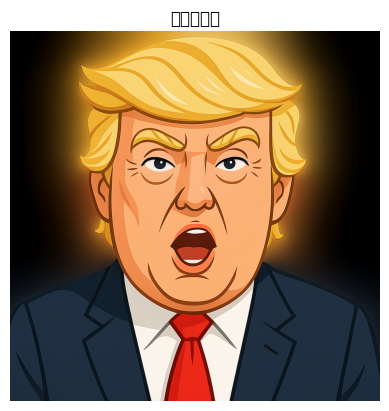

In [37]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 1 上傳圖片
uploaded = files.upload()

# 2 自動抓圖片檔名
filename = list(uploaded.keys())[0]
print("| file_name: ", filename)

# 3 打開圖片，抓取寬、高
img = Image.open(filename).convert("RGB") #開圖
width, height = img.size
print(f"| width X height: {width} x {height}")

# 4 將圖片轉成 input.bin 並儲存
arr = np.array(img).astype(np.uint8)  # shape: (H, W, 3)
arr.tofile("input.bin")

# 5 將寬高寫在 width_height.txt 並儲存
with open("width_height.txt", "w") as f:
    f.write(f"{width} {height}\n")

# 6 顯示圖片
plt.imshow(arr)
plt.title("上傳的圖片")
plt.axis('off')
plt.show()


# 2. gray_scale.cu

In [38]:
%%writefile lab.cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <chrono>

// CPU -function
void grayscale_cpu(unsigned char* rgb, unsigned char* gray, int width, int height) {
    for (int i = 0; i < width * height; ++i) {
        int r = rgb[3 * i];
        int g = rgb[3 * i + 1];
        int b = rgb[3 * i + 2];
        gray[i] = 0.299f * r + 0.587f * g + 0.114f * b;
    }
}

// GPU - kernel - ver1（global memory）
__global__ void grayscale_gpu_1(const unsigned char* rgb, unsigned char* gray, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int idx = y * width + x; // 2D -> 1D（因為圖是 2D，但記憶體是 1D）

    if (x < width && y < height) {
        int rgbIdx = 3 * idx;
        unsigned char r = rgb[rgbIdx];
        unsigned char g = rgb[rgbIdx + 1];
        unsigned char b = rgb[rgbIdx + 2];
        gray[idx] = 0.299f * r + 0.587f * g + 0.114f * b;
    }
}

// GPU - kernel - ver2（shared memory）
__global__ void grayscale_gpu_2(const unsigned char* rgb, unsigned char* gray, int width, int height) {
    extern __shared__ unsigned char tile_rgb[];

    int tx = threadIdx.x, ty = threadIdx.y;
    int x = blockIdx.x * blockDim.x + tx;
    int y = blockIdx.y * blockDim.y + ty;
    int idx = y * width + x;
    int t_idx = (ty * blockDim.x + tx) * 3;

    // 1) 將 global memory 的 rgb 資料載入到 shared memory 中
    //    tips: 記得等所有 thread 載入完畢再一起處理
    if (x < width && y < height) {
        tile_rgb[t_idx]     = rgb[3 * idx];
        tile_rgb[t_idx + 1] = rgb[3 * idx + 1];
        tile_rgb[t_idx + 2] = rgb[3 * idx + 2];
    }
    __syncthreads();

    // 2) 從 shared memory 中計算灰階
    if (x < width && y < height) {
        unsigned char r = tile_rgb[t_idx];
        unsigned char g = tile_rgb[t_idx + 1];
        unsigned char b = tile_rgb[t_idx + 2];
        gray[idx] = 0.299f * r + 0.587f * g + 0.114f * b;
    }
}

int main() {

    // 1. 讀取圖片寬高（從 width_height.txt）
    int width, height;
    FILE* fmeta = fopen("width_height.txt", "r");
    fscanf(fmeta, "%d %d", &width, &height);
    fclose(fmeta);

    size_t rgbSize = width * height * 3;  // RGB 彩色圖片的大小
    size_t graySize = width * height; // 灰階圖片的大小

    // 2. 讀取圖片像素資料（從 input.bin）
    FILE* fp = fopen("input.bin", "rb");
    unsigned char* h_rgb = new unsigned char[rgbSize];
    fread(h_rgb, 1, rgbSize, fp);
    fclose(fp);

    /// CPU 版本 --------------------------------------------
    unsigned char* h_gray_cpu = new unsigned char[graySize];
    auto t0 = std::chrono::high_resolution_clock::now();
    grayscale_cpu(h_rgb, h_gray_cpu, width, height);
    auto t1 = std::chrono::high_resolution_clock::now();
    float time_cpu = std::chrono::duration<float, std::milli>(t1 - t0).count();
    printf("CPU Time: %.2f ms\n", time_cpu);

    // GPU 版本 （CPU呼叫GPU）-----------------------------------

    // 3. 配置 GPU 記憶體
    unsigned char *d_rgb, *d_gray1, *d_gray2;
    cudaMalloc(&d_rgb, rgbSize);
    cudaMalloc(&d_gray1, graySize);
    cudaMalloc(&d_gray2, graySize);

    // 4. 把資料從CPU運到GPU
    cudaMemcpy(d_rgb, h_rgb, rgbSize, cudaMemcpyHostToDevice);

    // 5. 設定 block 與 grid（這裡每個 block 是 16x16）
    dim3 block(16, 16);
    dim3 grid((width + 15) / 16, (height + 15) / 16);

    // 6. GPU ver1
    t0 = std::chrono::high_resolution_clock::now();
    grayscale_gpu_1<<<grid, block>>>(d_rgb, d_gray1, width, height);
    cudaDeviceSynchronize();
    t1 = std::chrono::high_resolution_clock::now();
    float time_gpu1 = std::chrono::duration<float, std::milli>(t1 - t0).count();

    // 6. GPU ver2
    t0 = std::chrono::high_resolution_clock::now();
    grayscale_gpu_2<<<grid, block, block.x * block.y * 3>>>(d_rgb, d_gray2, width, height);
    cudaDeviceSynchronize();
    t1 = std::chrono::high_resolution_clock::now();
    float time_gpu2 = std::chrono::duration<float, std::milli>(t1 - t0).count();

    // 7. 印出時間 & 檢查正確性 ---------------------------
    unsigned char* h_gpu1 = new unsigned char[graySize];
    unsigned char* h_gpu2 = new unsigned char[graySize];
    cudaMemcpy(h_gpu1, d_gray1, graySize, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_gpu2, d_gray2, graySize, cudaMemcpyDeviceToHost);

    bool same1 = true, same2 = true;
    for (int i = 0; i < graySize; ++i) {
        if (abs(h_gray_cpu[i] - h_gpu1[i]) > 1) same1 = false;
        if (abs(h_gray_cpu[i] - h_gpu2[i]) > 1) same2 = false;
    }

    printf("GPU 1 (global) Time: %.2f ms | Check: %s\n", time_gpu1, same1 ? "OK" : "DIFF");
    printf("GPU 2 (shared) Time: %.2f ms | Check: %s\n", time_gpu2, same2 ? "OK" : "DIFF");

    // 8. 儲存三個版本的灰階 output
    FILE* f_out = fopen("output_cpu.bin", "wb");
    fwrite(h_gray_cpu, 1, graySize, f_out);
    fclose(f_out);

    FILE* f_out1 = fopen("output_gpu1.bin", "wb");
    fwrite(h_gpu1, 1, graySize, f_out1);
    fclose(f_out1);

    FILE* f_out2 = fopen("output_gpu2.bin", "wb");
    fwrite(h_gpu2, 1, graySize, f_out2);
    fclose(f_out2);

    // 9. 釋放 GPU malloc 的記憶體
    delete[] h_rgb;
    delete[] h_gray_cpu;
    delete[] h_gpu1;
    delete[] h_gpu2;
    cudaFree(d_rgb);
    cudaFree(d_gray1);
    cudaFree(d_gray2);
    return 0;
}



Writing lab.cu


In [39]:
!nvcc -arch=sm_75 lab.cu -o lab
!./lab

CPU Time: 6.01 ms
GPU 1 (global) Time: 0.16 ms | Check: OK
GPU 2 (shared) Time: 0.07 ms | Check: OK


# 3. output.py

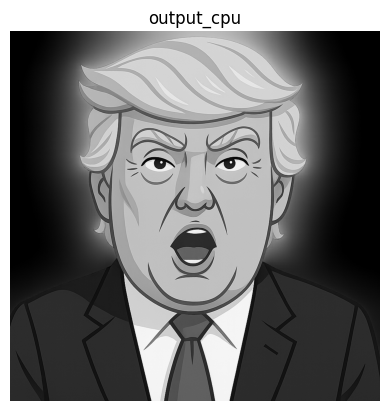

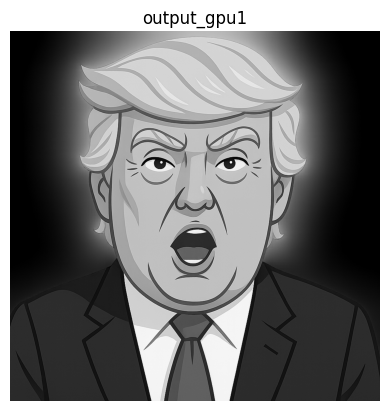

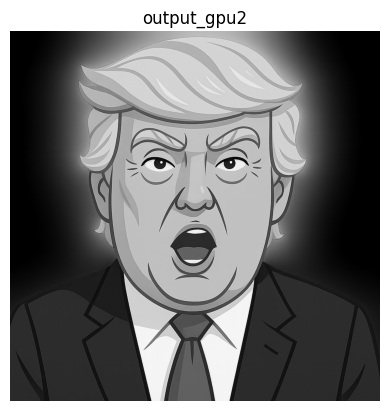

In [40]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 將 .bin 轉回 .png 的 function
def show(path, name):

    # 1 打開 width_height.txt，抓出寬、高
    with open("width_height.txt", "r") as f:
      width, height = map(int, f.read().strip().split())

    # 2 從 .bin 檔中讀取灰階像素（每個 pixel 1 byte）
    arr = np.fromfile(path, dtype=np.uint8).reshape((height, width))

    # 3 轉為 PIL Image
    img = Image.fromarray(arr).convert("L")

    # 4 儲存成 .png
    img.save(f"{name}.png")

    # 5 顯示圖片
    plt.imshow(arr, cmap='gray')
    plt.title(name)
    plt.axis('off')
    plt.show()

show("output_cpu.bin", "output_cpu")
show("output_gpu1.bin", "output_gpu1")
show("output_gpu2.bin", "output_gpu2")


# <小工具> 清空目前檔案中的所有檔案（txt, png...）

最好每次重新跑流程前先清空，以保持乾淨，避免舊檔案的干擾喔！

In [36]:
!rm -rf /content/*